# Desafío LATAM

### Importación de librerías

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patsy
import pymc as pm
import arviz as az

from datetime import datetime, timedelta, date, time
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from pandas.core.base import value_counts
from sklearn import preprocessing, tree, metrics
from sklearn import linear_model as lm
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.metrics import   accuracy_score, classification_report
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm, beta, halfnorm, rayleigh, poisson

### Lectura y exploración de datos

In [319]:
datos = pd.read_csv("/dataset_SCL.csv")
datos.head()

<ipython-input-319-64d0e4af9c25>:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv("/dataset_SCL.csv")


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [320]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [321]:
datos

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [322]:
viajes_aerolinea = datos.groupby("Emp-O").count()["Fecha-I"]

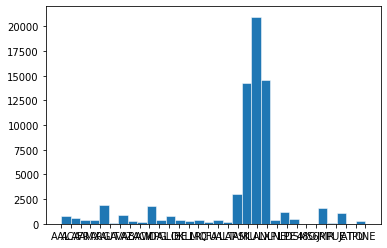

In [323]:
fig, ax = plt.subplots()

ax.hist(datos["Emp-O"], bins=32, linewidth=0.5, edgecolor="white")

plt.show()

In [324]:
viajes_aerolinea = value_counts(datos["Emp-O"])[0:3]
viajes_aerolinea

LAN    20988
LXP    14558
SKU    14298
Name: Emp-O, dtype: int64

Este gráfico muestra la cantidad de vuelos operados por cada aerolínea. Se observa claramente que hay tres empresas operando muchísimos más vuelos que las demás, las cuales son LAN, LXP y SKU.

In [325]:
emp_dist = datos[datos["Emp-I"] != datos["Emp-O"]]

In [326]:
emp_dist.shape
emp_dist.shape[0]/datos.shape[0]

0.273714922440841

Notar que 18.669 vuelos son operados por empresas distintas a la programada, lo que corresponde a un 27% aproximadamente.

In [327]:
value_counts(datos["TIPOVUELO"])

N    36966
I    31240
Name: TIPOVUELO, dtype: int64

Notar que no hay gran diferencia entre la cantidad de vuelos nacionales e internacionales.

In [328]:
datos.groupby(["Emp-O","TIPOVUELO"],as_index=False).agg(Cantidad=("TIPOVUELO",value_counts))

,Emp-O,TIPOVUELO,Cantidad
0,48O,I,10
1,56R,I,17
2,AAL,I,757
3,ACA,I,565
4,AFR,I,358
5,AMX,I,351
6,ARG,I,1946
7,AUT,I,77
8,AVA,I,885
9,AZA,I,259


Solo 5 empresas operan vuelos nacionales: JAT, JMR, LAN, LXP y SKU.

* De los vuelos operados por JAT, un 99% son nacionales.

* De los vuelos operados por JMR, un 39% son nacionales.

* De los vuelos operados por LAN, un 44% son nacionales.

* Todos los vuelos operados por LXP son nacionales.

* De los vuelos operados por SKU, un 80% son nacionales.

In [329]:
value_counts(datos["Ori-O"])

SCEL    68206
Name: Ori-O, dtype: int64

Todos los vuelos parten en Santiago.

In [330]:
value_counts(datos["Des-O"])

SCFA    5786
SPJC    5270
SCCF    5146
SCTE    4357
SCIE    3993
        ... 
SEQM       2
KIAD       1
SPSO       1
EGYP       1
SLCB       1
Name: Des-O, Length: 63, dtype: int64

El 2017 salieron vuelos a 63 destinos diferentes desde Santiago.

In [331]:
value_counts(datos["DIANOM"])

Viernes      10292
Jueves       10251
Lunes        10131
Domingo       9796
Miercoles     9722
Martes        9662
Sabado        8352
Name: DIANOM, dtype: int64

Los días con más vuelos son Lunes, Jueves y Viernes, mientras que el con menos es el Sábado.

In [332]:
grupos = datos.groupby(["AÑO", "MES", "DIA"]).groups

In [333]:
largo = []
fechas = []
for fecha,vuelos in grupos.items():
  largo.append(vuelos.shape[0])
  fechas.append(str(fecha[0])+"-"+str(fecha[1])+"-"+str(fecha[2]))

<BarContainer object of 366 artists>

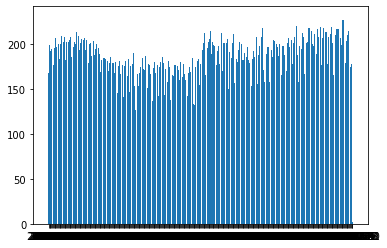

In [334]:
plt.bar(fechas, largo)

Se puede observar que la segunda mitad del año hay más vuelos que la primera, con algunos peaks a principio, mediado y final de año.

Sin hacer transformaciones de los datos, tenemos que casi todas la variables son objetos no numéricos, con excepción de las fechas, por lo que es difícil sacar conclusiones más que contando elementos por categorías.

### Agregar columnas

In [335]:
cond1 = datetime(2017,3,3,23,59,59)
cond2 = datetime(2017,7,15,0,0,0)
cond3 = datetime(2017,7,31,23,59,59)
cond4 = datetime(2017,9,11,0,0,0)
cond5 = datetime(2017,9,30,23,59,59)
cond6 = datetime(2017,12,15,0,0,0)

In [336]:
datos["Fecha-I"] = pd.to_datetime(datos["Fecha-I"])
datos["Fecha-O"] = pd.to_datetime(datos["Fecha-O"])

In [337]:
HS = []
for fecha in datos["Fecha-I"]:
  if fecha<cond1 or (fecha<cond3 and fecha>cond2) or (fecha<cond5 and fecha>cond4) or fecha>cond6:
    HS.append(1)
  else:
    HS.append(0)

In [338]:
datos["high_season"] = HS

In [339]:
datos["min_diff"] = datos["Fecha-O"] - datos["Fecha-I"]
minutos = []
for diferencia in datos["min_diff"]:
  minutos.append(diferencia.total_seconds()/60)
datos["min_diff"] = minutos

In [340]:
delay = []
for elem in datos["min_diff"]:
  if elem > 15:
    delay.append(1)
  else:
    delay.append(0)
datos["delay_15"] = delay

In [341]:
h1 = time(5)
h2 = time(11,59)
h3 = time(12)
h4 = time(18,59)
h5 = time(19)
h6 = time(4,59)

In [342]:
horario = []
for elem in datos["Fecha-I"]:
  if elem.time()>=h1 and elem.time()<=h2:
    horario.append("morning")
  elif elem.time()>=h3 and elem.time()<=h4:
    horario.append("afternoon")
  else:
    horario.append("night")
datos["period_day"] = horario

Luego de agregar todas las columnas pedidas, creamos el archivo synthetic_features.csv.

In [343]:
datos.to_csv('/synthetic_features.csv')

### Análisis con nuevas variables

Observemos primero el comportamiento de los minutos de retraso de los vuelos.

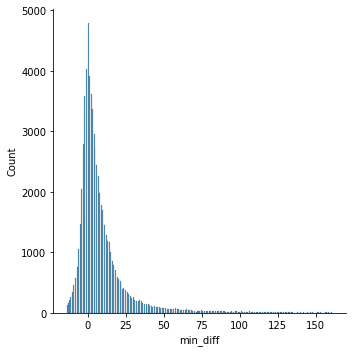

In [344]:
sns.displot(datos["min_diff"])

In [345]:
datos["min_diff"].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: min_diff, dtype: float64

<Axes: xlabel='Des-O', ylabel='min_diff'>

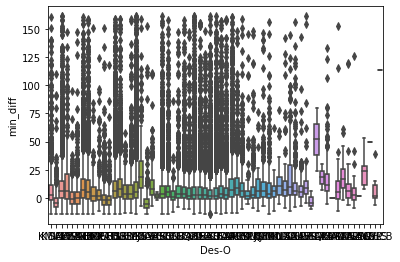

In [346]:
sns.boxplot(x='Des-O', y='min_diff', data=datos)

<Axes: xlabel='Des-O'>

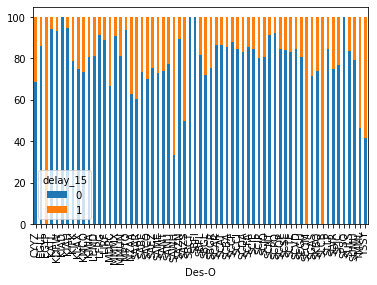

In [347]:
pd.crosstab(index=datos['Des-O'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

<Axes: xlabel='Emp-O', ylabel='min_diff'>

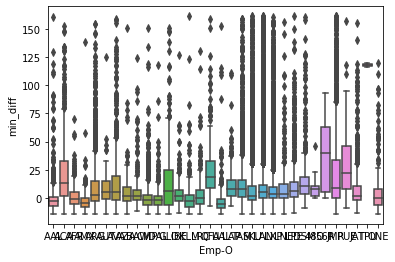

In [348]:
sns.boxplot(x='Emp-O', y='min_diff', data=datos)

<Axes: xlabel='Emp-O'>

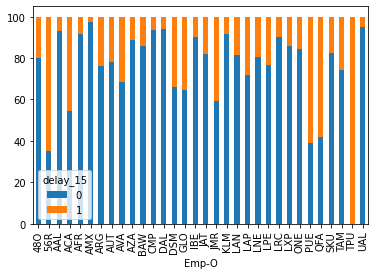

In [349]:
pd.crosstab(index=datos['Emp-O'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

<Axes: xlabel='MES', ylabel='min_diff'>

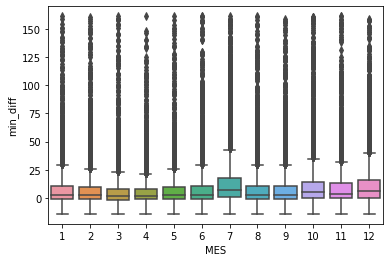

In [350]:
sns.boxplot(x='MES', y='min_diff', data=datos)

<Axes: xlabel='MES'>

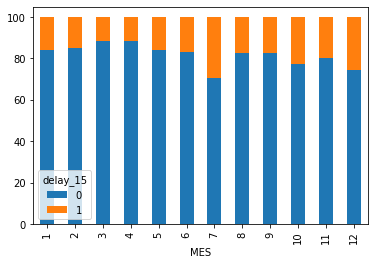

In [351]:
pd.crosstab(index=datos['MES'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

<Axes: xlabel='DIANOM', ylabel='min_diff'>

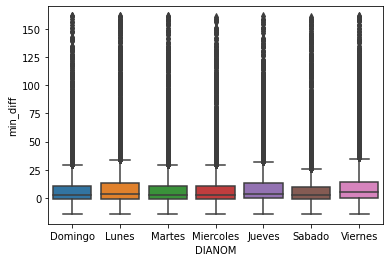

In [352]:
sns.boxplot(x='DIANOM', y='min_diff', data=datos)

<Axes: xlabel='DIANOM'>

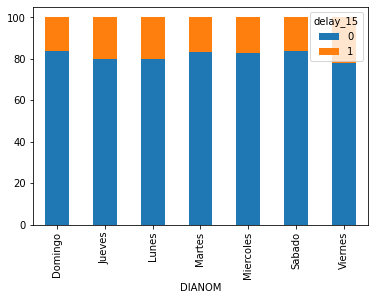

In [353]:
pd.crosstab(index=datos['DIANOM'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

<Axes: xlabel='high_season', ylabel='min_diff'>

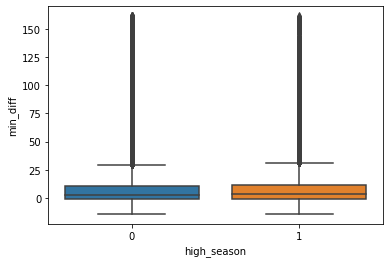

In [354]:
sns.boxplot(x='high_season', y='min_diff', data=datos)

<Axes: xlabel='high_season'>

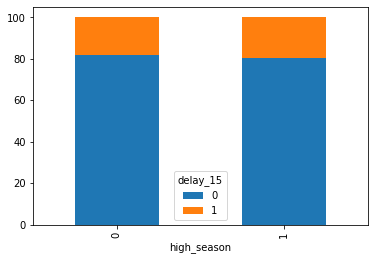

In [355]:
pd.crosstab(index=datos['high_season'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

<Axes: xlabel='TIPOVUELO', ylabel='min_diff'>

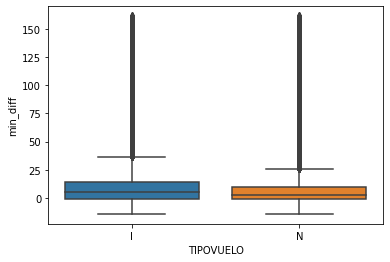

In [356]:
sns.boxplot(x='TIPOVUELO', y='min_diff', data=datos)

<Axes: xlabel='TIPOVUELO'>

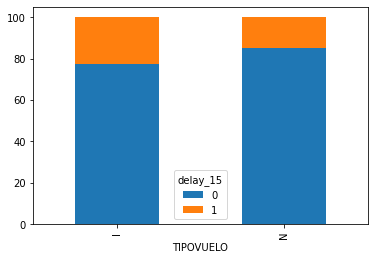

In [357]:
pd.crosstab(index=datos['TIPOVUELO'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

Se puede observar que las barras de los dos primeros gráficos de barra están muy fluctuantes, lo qu eindica que el destino y empresa que opera el vuelo podrían ser variables influyentes en el retraso de un vuelo.

Luego, se nota una ligera diferencia de mayor retraso en vuelos internacionales que nacionales, pero habría que analizar en mayor profundidad si esa diferencia es o no significativa. Lo mismo con el mes del año. Julio y Diciembre presentan más atrasos, pero en general se ven barras parejas.

Por otra parte, las barras de día de la semana y temporada no tienen mucha diferencia. Así, esas variables no debiesen impactar en el retraso de vuelos.

Se crea una variable nueva que indica si el destino programado es igual al destino operado.

In [358]:
destino = []
igualdad = datos["Des-I"] == datos["Des-O"]
for elem in igualdad:
  if elem:
    destino.append(0)
  else:
    destino.append(1)
datos["cambio_destino"] = destino

# 0 si hay cambio de destino, 1 si se mantiene la ruta.

<Axes: xlabel='cambio_destino', ylabel='min_diff'>

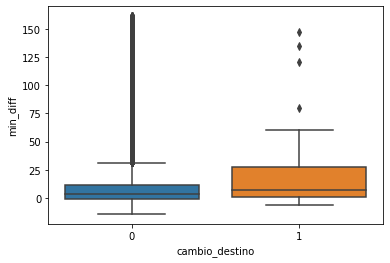

In [359]:
sns.boxplot(x='cambio_destino', y='min_diff', data=datos)

<Axes: xlabel='cambio_destino'>

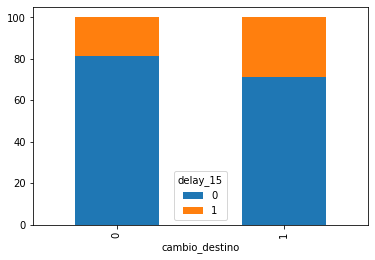

In [360]:
pd.crosstab(index=datos['cambio_destino'],columns=datos['delay_15']).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

Notar que el cambio de destino podría influir en el retraso del vuelo.

### Entrenamiento de modelos

Primero se crean las variables predictoras x y la variable respuesta y (correspondiente a si el vuelo se atrasó mas o menos de 15 minutos). Y se hace una partición train (70%) - test (30%).

In [361]:
datos['TIPOVUELO'] = datos['TIPOVUELO'].replace('N',0)
datos['TIPOVUELO'] = datos['TIPOVUELO'].replace('I',1)

In [362]:
y = datos.delay_15
x = datos.drop(["min_diff", "Fecha-I", "Vlo-I", "Ori-I", "Des-I", "Emp-I", 
                "Fecha-O", "Ori-O", "Vlo-O", "Des-O", "DIA", "AÑO", "OPERA", 
                "SIGLAORI", "SIGLADES", "delay_15"], axis = 1)

In [363]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.3)

Se generan variables dummies y se balancea la muestra con método básico.

In [364]:
x_train = pd.get_dummies(x_train, columns=["MES", "Emp-O", "DIANOM", "period_day"])
x_test = pd.get_dummies(x_test, columns=["MES", "Emp-O", "DIANOM", "period_day"])

In [365]:
os = RandomOverSampler(random_state = 0)
x_train_o, y_train_o = os.fit_resample(x_train, y_train)

Se elimina la columna de la empresa TPU, pues no existe en la base de train y genera error.

In [366]:
x_test = x_test.drop("Emp-O_TPU", axis=1)

Para analizar los siguientes resultados, se utilizan como medidores:
* Accuracy: % de aciertos sobre el total.
* Precision: % de aciertos sobre las predicciones.
* Recall: % de aciertos sobre los valores reales.
* Curva ROC: comportamiento entre recall de atrasos y no atrasos.
* AUC: área bajo la curva ROC (regular entre 0.6 y 0.75, bueno entre 0.75 y 0.9).

##### Árbol de decisión (Gini)

Se comienza usando parámetros aleatorios, para analizar comportamiento. Luego, se usará una grilla para ver valores óptimos.

In [367]:
arbol = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 4, min_samples_leaf = 50, min_samples_split = 200)
arbol = arbol.fit(x_train_o, y_train_o)
preds = arbol.predict(x_test)

[Text(0.5, 0.9, 'TIPOVUELO <= 0.5\ngini = 0.5\nsamples = 77884\nvalue = [38942, 38942]'),
 Text(0.25, 0.7, 'MES_7 <= 0.5\ngini = 0.492\nsamples = 39012\nvalue = [22008, 17004]'),
 Text(0.125, 0.5, 'MES_12 <= 0.5\ngini = 0.486\nsamples = 34905\nvalue = [20417, 14488]'),
 Text(0.0625, 0.3, 'MES_10 <= 0.5\ngini = 0.478\nsamples = 30584\nvalue = [18528, 12056]'),
 Text(0.03125, 0.1, 'gini = 0.468\nsamples = 26637\nvalue = [16700, 9937]'),
 Text(0.09375, 0.1, 'gini = 0.497\nsamples = 3947\nvalue = [1828, 2119]'),
 Text(0.1875, 0.3, 'period_day_morning <= 0.5\ngini = 0.492\nsamples = 4321\nvalue = [1889, 2432]'),
 Text(0.15625, 0.1, 'gini = 0.464\nsamples = 2803\nvalue = [1024, 1779]'),
 Text(0.21875, 0.1, 'gini = 0.49\nsamples = 1518\nvalue = [865, 653]'),
 Text(0.375, 0.5, 'DIANOM_Domingo <= 0.5\ngini = 0.475\nsamples = 4107\nvalue = [1591, 2516]'),
 Text(0.3125, 0.3, 'DIANOM_Martes <= 0.5\ngini = 0.464\nsamples = 3551\nvalue = [1301, 2250]'),
 Text(0.28125, 0.1, 'gini = 0.472\nsamples = 2

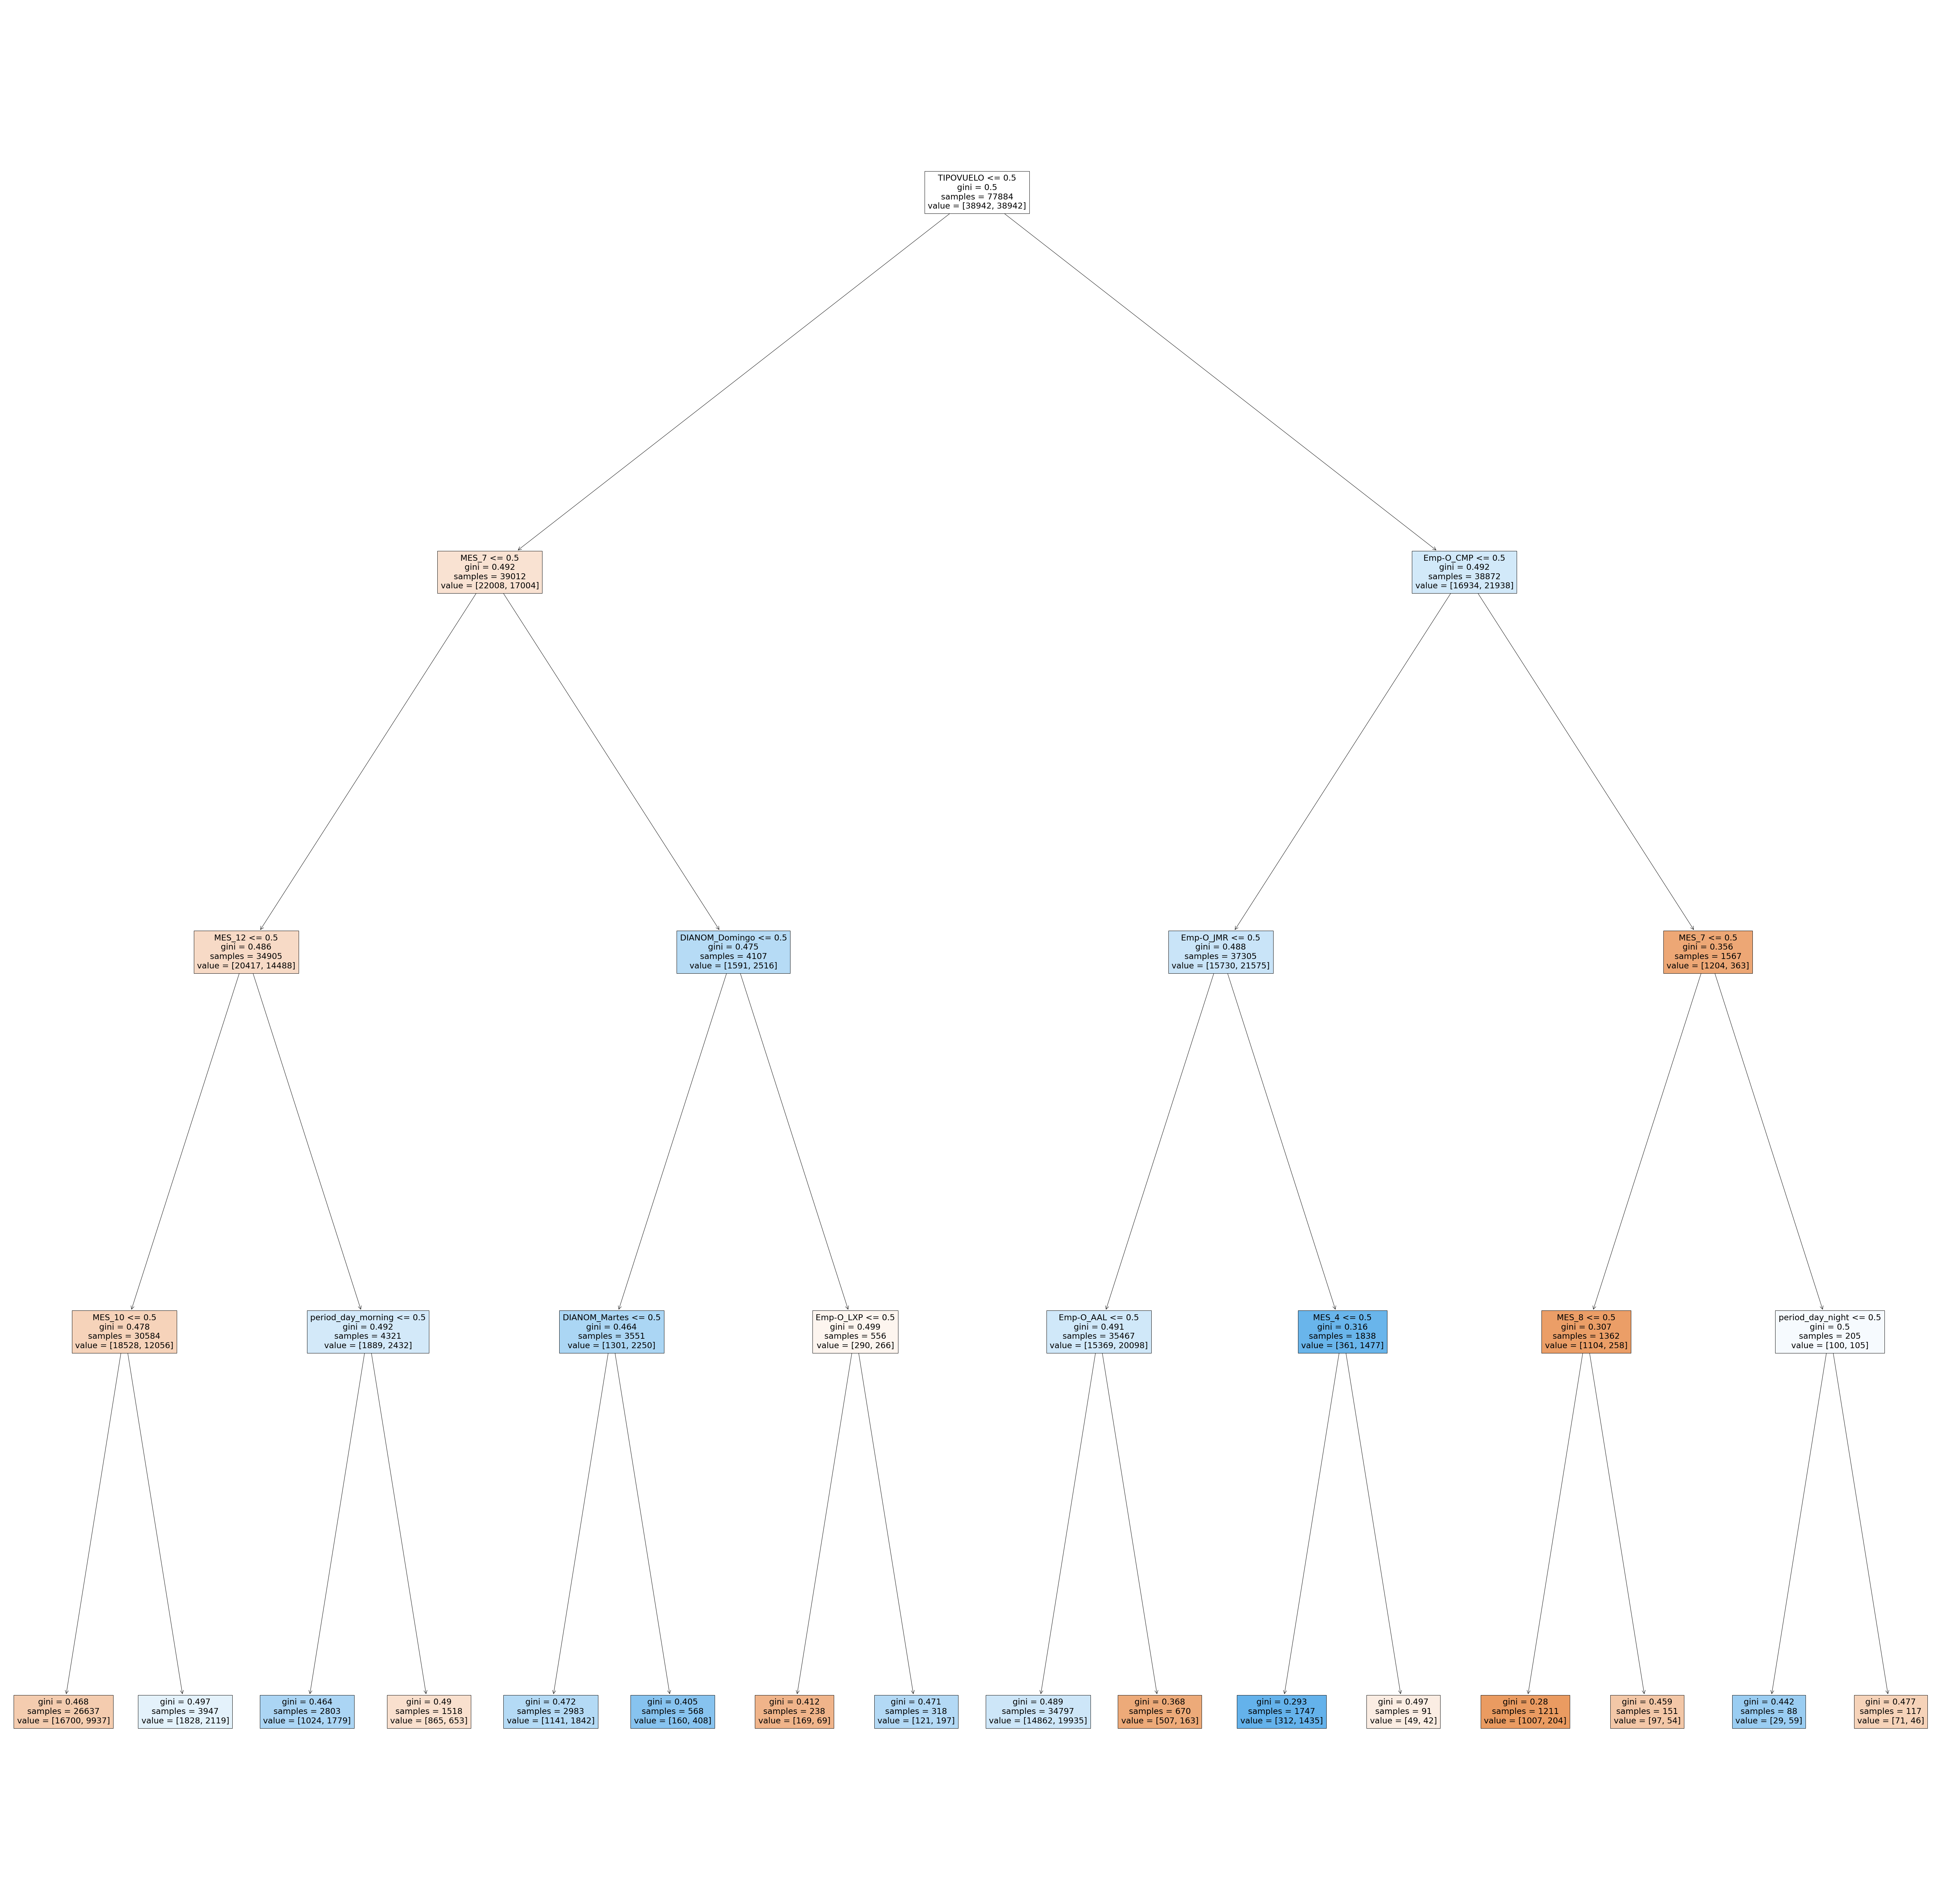

In [368]:
plt.figure(figsize=(100, 100))
tree.plot_tree(arbol, feature_names = x_train_o.columns, filled = True)

In [369]:
metrics.confusion_matrix(y_test, preds)

array([[8189, 8461],
       [1105, 2707]])

In [370]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.49      0.63     16650
           1       0.24      0.71      0.36      3812

    accuracy                           0.53     20462
   macro avg       0.56      0.60      0.50     20462
weighted avg       0.76      0.53      0.58     20462



In [371]:
roc = metrics.roc_curve(y_test, preds)
metrics.roc_auc_score(y_test, preds)

0.6009788749925162

Los resultados no son tan buenos, solo el valor de la precisión para los vuelos con atraso menor a 15 minutos da un valor alto del 88%.

Según este modelo, las variables más relevantes son el tipo de vuelo, meses de julio y diciembre, empresas CMP y JMR, y día Domingo.

#### Árbol de decisión (Bagging)

In [372]:
arboles = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'gini', 
                                                                       max_depth = 4, 
                                                                       min_samples_leaf = 50, 
                                                                       min_samples_split = 200),
                            n_estimators = 100)

In [373]:
arboles_fit = arboles.fit(x_train_o, y_train_o)
preds_arboles = arboles_fit.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [374]:
metrics.confusion_matrix(y_test, preds_arboles)

array([[8137, 8513],
       [1099, 2713]])

In [375]:
print(metrics.classification_report(y_test, preds_arboles))

              precision    recall  f1-score   support

           0       0.88      0.49      0.63     16650
           1       0.24      0.71      0.36      3812

    accuracy                           0.53     20462
   macro avg       0.56      0.60      0.49     20462
weighted avg       0.76      0.53      0.58     20462



In [376]:
roc = metrics.roc_curve(y_test, preds_arboles)
metrics.roc_auc_score(y_test, preds_arboles)

0.6002043018884572

Notar que estos son los mismos resultados que en el modelo anterior del árbol de decisión simple con método Gini.

#### Árbol de decisión (AdaBoost)

In [377]:
modelo_ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion = 'gini', 
                                                                             max_depth = 4, 
                                                                             min_samples_leaf = 50, 
                                                                             min_samples_split = 200), 
                                n_estimators = 100)

In [378]:
grilla = {'n_estimators': [100, 120, 140],
          'learning_rate': [0.4, 0.6],
          'random_state': [123]}

gsearch_a = GridSearchCV(modelo_ada,
                         param_grid = grilla, 
                         cv = 5)
gsearch_a.fit(x_train_o, y_train_o)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                                                min_samples_leaf=50,
                                                                                min_samples_split=200),
                                          n_estimators=100),
             param_grid={'learning_rate': [0.4, 0.6],
                         'n_estimators': [100, 120, 140],
                         'random_state': [123]})

In [379]:
resultados = pd.DataFrame(gsearch_a.cv_results_).sort_values(['rank_test_score'])
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,17.988235,0.740982,0.418172,0.011969,0.6,140,123,"{'learning_rate': 0.6, 'n_estimators': 140, 'r...",0.664826,0.660975,0.662708,0.659113,0.667180,0.662960,0.002832,1
3,13.162939,0.472049,0.309130,0.011163,0.6,100,123,"{'learning_rate': 0.6, 'n_estimators': 100, 'r...",0.663928,0.660525,0.661745,0.660782,0.665896,0.662575,0.002048,2
4,15.157409,0.387068,0.402143,0.088905,0.6,120,123,"{'learning_rate': 0.6, 'n_estimators': 120, 'r...",0.664570,0.660012,0.662515,0.659177,0.666346,0.662524,0.002695,3
2,18.226212,0.346637,0.430680,0.006870,0.4,140,123,"{'learning_rate': 0.4, 'n_estimators': 140, 'r...",0.661231,0.660718,0.662387,0.660975,0.663457,0.661753,0.001025,4
1,15.682601,0.325387,0.400063,0.081105,0.4,120,123,"{'learning_rate': 0.4, 'n_estimators': 120, 'r...",0.658663,0.660525,0.662066,0.660654,0.663392,0.661060,0.001590,5
0,12.702712,0.240824,0.340031,0.066999,0.4,100,123,"{'learning_rate': 0.4, 'n_estimators': 100, 'r...",0.657187,0.660333,0.658535,0.660846,0.662815,0.659943,0.001939,6


Los mejores parámetros son n-estimador=140 y learning rate=0.6, por lo que se elige para el siguiente modelo.

In [380]:
modelo_ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion = 'gini', 
                                                                             max_depth = 4, 
                                                                             min_samples_leaf = 50, 
                                                                             min_samples_split = 200), 
                                learning_rate = gsearch_a.best_params_['learning_rate'],
                                n_estimators = gsearch_a.best_params_['n_estimators'],
                                random_state = 123)

In [381]:
modelo_ada_fit = modelo_ada.fit(x_train_o, y_train_o)
preds_ada = modelo_ada_fit.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [382]:
metrics.confusion_matrix(y_test, preds_ada)

array([[10789,  5861],
       [ 1395,  2417]])

In [383]:
print(metrics.classification_report(y_test, preds_ada))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     16650
           1       0.29      0.63      0.40      3812

    accuracy                           0.65     20462
   macro avg       0.59      0.64      0.57     20462
weighted avg       0.77      0.65      0.68     20462



In [384]:
roc = metrics.roc_curve(y_test, preds_ada)
metrics.roc_auc_score(y_test, preds_ada)

0.6410191776246341

In [385]:
prob_ada = modelo_ada_fit.predict_proba(x_test)[:, 1]
prob_ada

array([0.50225047, 0.50066023, 0.50048831, ..., 0.49964518, 0.506652  ,
       0.49977916])

Acá dan mejores resultados que en modelos anteriores por el momento, con accuracy y f1-score más altos. Además, el área bajo la curva ROC es del 64% aproximadamente, lo que indica un ajuste de modelo regular.

#### Árbol de decisión (lightGBM)

In [386]:
grilla = {'max_depth': [6, 7, 8, 9],
          'n_estimators': [80, 100, 120, 140],
          'learning_rate': [0.3, 0.4, 0.5, 0.6],
          'random_state': [123]}

gsearch_c = GridSearchCV(LGBMClassifier(),
                         param_grid = grilla, 
                         cv = 5)
gsearch_c.fit(x_train_o, y_train_o)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.3, 0.4, 0.5, 0.6],
                         'max_depth': [6, 7, 8, 9],
                         'n_estimators': [80, 100, 120, 140],
                         'random_state': [123]})

In [387]:
print(gsearch_c.best_params_)

{'learning_rate': 0.6, 'max_depth': 8, 'n_estimators': 140, 'random_state': 123}


In [388]:
lgbm_c = LGBMClassifier(learning_rate = gsearch_c.best_params_['learning_rate'],
                        n_estimators = gsearch_c.best_params_['n_estimators'],
                        max_depth = gsearch_c.best_params_['max_depth'],
                        random_state = 123)
ajuste = lgbm_c.fit(x_train_o, y_train_o)
preds_c = ajuste.predict(x_test)

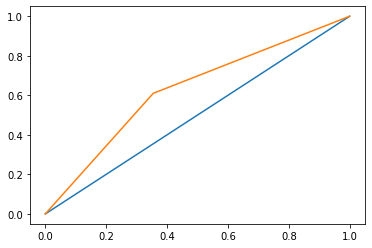

In [389]:
roc = metrics.roc_curve(y_test, preds_c)
plt.plot([0,1], [0,1])
plt.plot(roc[0], roc[1])

In [390]:
metrics.roc_auc_score(y_test, preds_c)

0.6276717746077662

In [391]:
print(metrics.classification_report(y_test, preds_c))

              precision    recall  f1-score   support

           0       0.88      0.65      0.74     16650
           1       0.28      0.61      0.39      3812

    accuracy                           0.64     20462
   macro avg       0.58      0.63      0.57     20462
weighted avg       0.77      0.64      0.68     20462



In [392]:
prob_lgbm = ajuste.predict_proba(x_test)[:, 1]

Con este modelo, elárea bajo la curva ROC es 63% aproximadamente, lo que es un resultado regular.

#### Random forrest

In [393]:
clf = RandomForestClassifier(n_estimators=120, criterion='gini',max_depth=5,max_features='log2')
clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=120)

In [394]:
y_pred = clf.predict(x_test)

In [395]:
print('Accuracy: %.3f' % (metrics.accuracy_score(y_test, y_pred)*100),'%')

Accuracy: 81.370 %


In [396]:
metrics.confusion_matrix(y_test, y_pred)

array([[16650,     0],
       [ 3812,     0]])

In [397]:
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16650
           1       0.00      0.00      0.00      3812

    accuracy                           0.81     20462
   macro avg       0.41      0.50      0.45     20462
weighted avg       0.66      0.81      0.73     20462



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [398]:
roc = metrics.roc_curve(y_test, y_pred)
metrics.roc_auc_score(y_test, y_pred)

0.5

Se puede ver que clasifica todos los vuelos como sin atraso y la curva ROC indica que es un mal modelo.

In [399]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy',max_depth=6, n_jobs=3, min_samples_leaf=2, max_features='sqrt', class_weight='balanced')
clf.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=2, n_estimators=10,
                       n_jobs=3)

In [400]:
y_pred = clf.predict(x_test)

In [401]:
print('Accuracy: %.3f' % (metrics.accuracy_score(y_test, y_pred)*100),'%')

Accuracy: 59.857 %


In [402]:
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.88      0.59      0.71     16650
           1       0.26      0.63      0.37      3812

    accuracy                           0.60     20462
   macro avg       0.57      0.61      0.54     20462
weighted avg       0.76      0.60      0.64     20462



In [403]:
roc = metrics.roc_curve(y_test, y_pred)
metrics.roc_auc_score(y_test, y_pred)

0.6124526782816395

Se puede ver que la precisión de los vuelos con retraso es muy baja y la curva ROC indica que es un modelo regular.

In [404]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5, max_features='log2')
clf.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       n_estimators=10)

In [405]:
y_pred = clf.predict(x_test)

In [406]:
print('Accuracy: %.3f' % (metrics.accuracy_score(y_test, y_pred)*100),'%')

Accuracy: 81.375 %


In [407]:
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16650
           1       1.00      0.00      0.00      3812

    accuracy                           0.81     20462
   macro avg       0.91      0.50      0.45     20462
weighted avg       0.85      0.81      0.73     20462



In [408]:
roc = metrics.roc_curve(y_test, y_pred)
metrics.roc_auc_score(y_test, y_pred)

0.5001311647429171

Se puede ver que clasifica todos los vuelos como sin atraso y la curva ROC indica que es un mal modelo.

#### KNN

In [409]:
err = []

for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance',algorithm='kd_tree')
    knn.fit(x_train, y_train)
    y_pred_i = knn.predict(x_test)
    err.append(np.mean(y_pred_i != y_test))

In [410]:
err

[0.2683510898250415,
 0.20017593588114554,
 0.22011533574430653,
 0.1966572182582348,
 0.20349916919167238,
 0.19382269572866778,
 0.19846544814778613,
 0.19196559476102043,
 0.19416479327533964,
 0.1897175251686052,
 0.19367608249437981,
 0.18913107223145342,
 0.19284527416674813,
 0.18854461929430164]

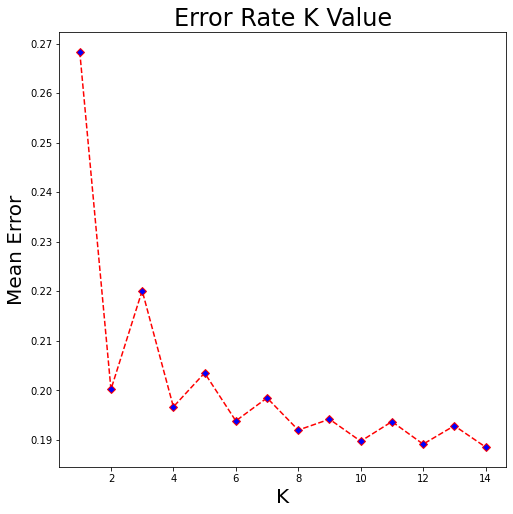

In [411]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot() 

ax.plot(range(1, 15), err, color='red', linestyle='dashed', marker='D',
         markerfacecolor='blue', markersize=5)
ax.set_title('Error Rate K Value',fontsize=24)
ax.set_xlabel('K',fontsize=20)
ax.set_ylabel('Mean Error',fontsize=20)

fig.show()

In [412]:
k_optimo = np.where(err==np.min(err))[0][0]+1
k_optimo

14

Observar que el error más bajo es para k = 14.

In [413]:
best_classifier = KNeighborsClassifier(n_neighbors=k_optimo, weights='distance',algorithm='kd_tree')
best_classifier.fit(x_train, y_train)
y_best_pred = best_classifier.predict(x_test)
print('Menor error medio con k=%i : %.3f' % (k_optimo,np.mean(y_best_pred != y_test)*100),'%')
print('Accuracy con k=%i : %.3f' % (k_optimo,metrics.accuracy_score(y_test, y_best_pred)*100),'%')

Menor error medio con k=14 : 18.854 %
Accuracy con k=14 : 81.146 %


In [414]:
metrics.confusion_matrix(y_test, y_best_pred)

array([[16128,   522],
       [ 3336,   476]])

In [415]:
print(classification_report(y_test, best_classifier.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     16650
           1       0.48      0.12      0.20      3812

    accuracy                           0.81     20462
   macro avg       0.65      0.55      0.55     20462
weighted avg       0.76      0.81      0.76     20462



In [416]:
roc = metrics.roc_curve(y_test, y_best_pred)
metrics.roc_auc_score(y_test, y_best_pred)

0.5467587419528657

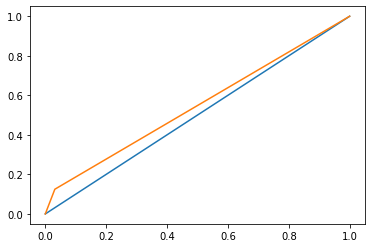

In [417]:
plt.plot([0,1], [0,1])
plt.plot(roc[0], roc[1])

Este modelo predice muy bien cuándo los vuelos NO se atrasan, pero muy mal cuando los vuelos SÍ se atrasan. Así, el área bajo la curva ROC es un 55% aproximadamente, lo que se clasifica como un modelo malo.

Hasta el momento, ninguno de los modelos propuestos es lo suficientemente bueno como para adoptarlo y se debe seguir buscando.

#### Regresión lineal

In [418]:
modelo = lm.LogisticRegression(max_iter=1000)
modelo.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [419]:
y_prediccion = modelo.predict(x_test)

In [420]:
probabilidades = modelo.predict_proba(x_test)[:, 1]

In [421]:
print(classification_report(y_test, y_prediccion))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16650
           1       0.50      0.03      0.06      3812

    accuracy                           0.81     20462
   macro avg       0.66      0.51      0.48     20462
weighted avg       0.76      0.81      0.74     20462



In [422]:
roc = metrics.roc_curve(y_test, y_prediccion)
metrics.roc_auc_score(y_test, y_prediccion)

0.5128140785066283

In [423]:
selector = RFECV(estimator=modelo, cv=10)
selector.fit(x_train, y_train)

# Imprimir los resultados
print("Número óptimo de características: %d" % selector.n_features_)
print("Ranking de características: %s" % selector.ranking_)


Número óptimo de características: 47
Ranking de características: [ 1  1  1  1  1  1  1  9 10  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  1
  1  7  8  5  1  4  1  3]


In [424]:
x_selected_train = x_train.loc[:, selector.ranking_ == 1]
x_selected_test = x_test.loc[:, selector.ranking_ == 1]

In [425]:
modelo_selected = lm.LogisticRegression(max_iter=1000)
modelo.fit(x_selected_train, y_train)

LogisticRegression(max_iter=1000)

In [426]:
y_prediccion_selected = modelo.predict(x_selected_test)

In [427]:
probabilidades_selected = modelo.predict_proba(x_selected_test)[:, 1]

In [428]:
print(classification_report(y_test, y_prediccion_selected))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16650
           1       0.51      0.04      0.07      3812

    accuracy                           0.81     20462
   macro avg       0.66      0.51      0.48     20462
weighted avg       0.76      0.81      0.74     20462



In [429]:
roc = metrics.roc_curve(y_test, y_prediccion_selected)
metrics.roc_auc_score(y_test, y_prediccion_selected)

0.5141778452114234

Nuevamente nos enfrentamos a un modelo que predice muy bien los vuelos puntuales , pero no tanto los atrasados, y el área bajo la curva ROC indica que es un mal modelo.

#### Intentar mejorar modelo

De todos los modelos ajustados, el que mejor predice es el árbol de decisión con AdaBoost. Tiene precisión y recall para vuelos puntuales y accuracy sobre 65%. La precisión de vuelos atrasados es baja, pero el recall es sobre el 60%. Además, el área bajo la curva ROC es de 64% aprox, el valor más alto de los modelos entrenados.

Se probarán algunas transformaciones, a ver si mejoran los resultados.Se agregará la variable cant_vuelos, que indica cuántos vuelos despegan una hora antes o después.

In [430]:
CV = []
for fecha in datos["Fecha-I"]:
  cantidad = (abs(datos["Fecha-I"] - fecha) < pd.Timedelta("1 hour")).sum()
  CV.append(cantidad)
datos["cant_vuelos1h"] = CV

<Axes: xlabel='delay_15', ylabel='cant_vuelos1h'>

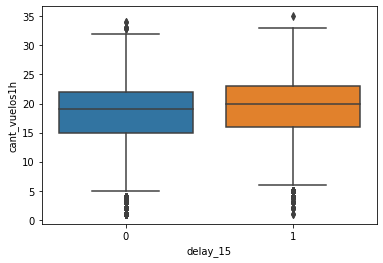

In [431]:
sns.boxplot(x='delay_15', y='cant_vuelos1h', data=datos)

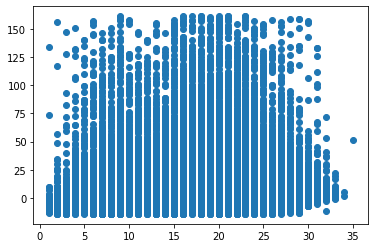

In [432]:
plt.scatter(datos["cant_vuelos1h"], datos["min_diff"])

Sin embargo, no se ve que estas variables nuevas sean tan significativas para el atraso de un vuelo. Ver si mejoran los resultados.

In [433]:
y = datos.delay_15
x = datos.drop(["min_diff", "Fecha-I", "Vlo-I", "Ori-I", "Des-I", "Emp-I", 
                "Fecha-O", "Ori-O", "Vlo-O", "Des-O", "DIA", "AÑO", "OPERA", 
                "SIGLAORI", "SIGLADES", "delay_15"], axis = 1)

In [434]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.3)

In [435]:
x_train = pd.get_dummies(x_train, columns=["MES", "Emp-O", "DIANOM", "period_day"])
x_test = pd.get_dummies(x_test, columns=["MES", "Emp-O", "DIANOM", "period_day"])

In [436]:
x_test = x_test.drop("Emp-O_TPU", axis=1)

In [437]:
os = RandomOverSampler(random_state = 0)
x_train_o, y_train_o = os.fit_resample(x_train, y_train)

In [438]:
modelo_ada_n = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion = 'gini', 
                                                                             max_depth = 4, 
                                                                             min_samples_leaf = 50, 
                                                                             min_samples_split = 200), 
                                learning_rate = 0.6,
                                n_estimators = 140,
                                random_state = 123)

In [439]:
modelo_ada_fit_n = modelo_ada_n.fit(x_train_o, y_train_o)
preds_ada_n = modelo_ada_fit_n.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [440]:
print(metrics.classification_report(y_test, preds_ada_n))

              precision    recall  f1-score   support

           0       0.89      0.66      0.75     16650
           1       0.30      0.63      0.40      3812

    accuracy                           0.65     20462
   macro avg       0.59      0.64      0.58     20462
weighted avg       0.78      0.65      0.69     20462



In [441]:
roc = metrics.roc_curve(y_test, preds_ada_n)
metrics.roc_auc_score(y_test, preds_ada_n)

0.6428482679951726

In [442]:
prob_ada_n = modelo_ada_fit_n.predict_proba(x_test)[:, 1]
prob_ada_n

array([0.50171381, 0.50106362, 0.49995509, ..., 0.49906549, 0.5079672 ,
       0.49977086])

El modelo de árbol AdaBoost mejora un poco al incorporar esta nueva variable, así que lo elegimos.

### Conclusiones

Haciendo un balance entre accuracy, recall, precision y AUC de todos los modelos, el que tiene mejores resultados es este último y es el que se adoptará.

Para este modelo, se verán las variables más importantes.

In [443]:
name_ = []
importance_ = []
for name, importance in zip(x_train.columns, modelo_ada_fit_n.feature_importances_): 
    print(name,":", importance)
    name_.append(name)
    importance_.append(importance)

TIPOVUELO : 0.029699081173881123
high_season : 0.029063598811271532
cambio_destino : 0.0021855604995459077
cant_vuelos1h : 0.26736866269093174
MES_1 : 0.014552497736044367
MES_2 : 0.015236102502447788
MES_3 : 0.01719459142456381
MES_4 : 0.013699539354456086
MES_5 : 0.015041725965995572
MES_6 : 0.013035374165999062
MES_7 : 0.013375102483460138
MES_8 : 0.014154546537938762
MES_9 : 0.017405835006711973
MES_10 : 0.012915016451452705
MES_11 : 0.01610904949549635
MES_12 : 0.021351115301586523
Emp-O_48O : 0.0
Emp-O_56R : 0.0
Emp-O_AAL : 0.006097345470433701
Emp-O_ACA : 0.0035751089601166867
Emp-O_AFR : 0.004889182944756414
Emp-O_AMX : 0.0058452898307971525
Emp-O_ARG : 0.014572936888228659
Emp-O_AUT : 0.006086957895403288
Emp-O_AVA : 0.012672725201771477
Emp-O_AZA : 0.002911914770695873
Emp-O_BAW : 0.0028447143049603074
Emp-O_CMP : 0.015628025652079755
Emp-O_DAL : 0.004961934322419727
Emp-O_DSM : 0.0024546019356187347
Emp-O_GLO : 0.006875147925268451
Emp-O_IBE : 0.004596516162685707
Emp-O_JAT 

In [444]:
featI = pd.DataFrame(importance_, columns=['FeatureValue'])
featI['FeatureName'] = name_
featI = featI.sort_values(by=['FeatureValue'], ascending=False)
featI.head(15)

,FeatureValue,FeatureName
3,0.267369,cant_vuelos1h
49,0.037474,DIANOM_Lunes
47,0.033716,DIANOM_Domingo
55,0.031862,period_day_morning
0,0.029699,TIPOVUELO
1,0.029064,high_season
44,0.027112,Emp-O_SKU
50,0.026597,DIANOM_Martes
54,0.025591,period_day_afternoon
56,0.025370,period_day_night


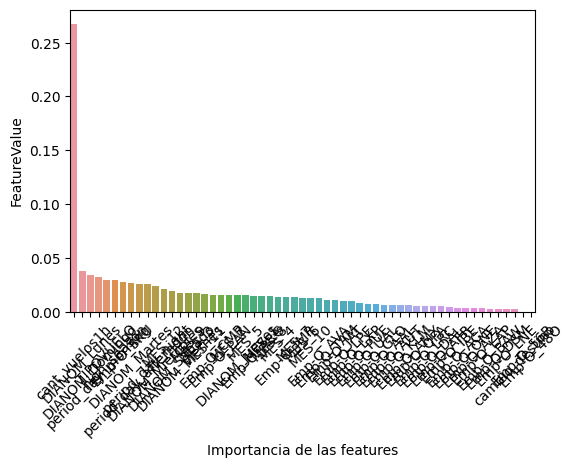

In [445]:
fig = plt.figure(dpi=100)
feat = sns.barplot(x='FeatureName', y='FeatureValue', data=featI)
plt.xlabel('Importancia de las features')

for item in feat.get_xticklabels():
    item.set_rotation(45)

In [446]:
featI[["FeatureName"]].head(15)

,FeatureName
3,cant_vuelos1h
49,DIANOM_Lunes
47,DIANOM_Domingo
55,period_day_morning
0,TIPOVUELO
1,high_season
44,Emp-O_SKU
50,DIANOM_Martes
54,period_day_afternoon
56,period_day_night


Bajo este modelo, las 15 variables más influyentes son Enero, Martes, Jueves, noche, tipo de vuelo, temporada alta, TAM, Miércoles, mañana, Sábado, 48O, Viernes, Octubre y Abril.

Para mejorar el modelo, se podría intentar incorporar a la base de datos y al modelo la cantidad de boletos y equipaje de mano vendidos, ya que mucha gente con maleta de mano entorpecen el ingreso al avión y podrían atrasar los vuelos.